In [1]:
import pandas as pd

df = pd.read_csv("../data/CMU_MisCov19_dataset_hydrated.csv")

In [2]:
print("Ratio of label occurrence between those tweets with and those tweets without user location")

t_with_l = df[df.country_code.notnull()]
t_without_l = df[~df.country_code.notnull()]
print( (t_with_l.annotation1.value_counts()/len(t_with_l)) / (t_without_l.annotation1.value_counts()/len(t_without_l)) )

Ratio of label occurrence between those tweets with and those tweets without user location
ambiguous or hard to classify        1.030614
calling out or correction            1.438762
commercial activity or promotion     1.130562
conspiracy                           0.394661
emergency                           15.375643
fake cure                            0.435907
fake treatment                       0.524170
false fact or prevention             1.003824
false public health response              NaN
irrelevant                           1.247585
news                                 2.690738
panic buying                         1.729760
politics                             1.055500
sarcasm or satire                    0.876072
true prevention                      2.694916
true public health response          2.599008
Name: annotation1, dtype: float64


Users with their location specified properly seems to be less likely to post tweets that could be classified to be about "conspiracies", "fake cures" and "fake treatments". While more likely to post tweets labeled "calling out or correction", "news", "panic buying", "true prevention" and "true public health response".

In [3]:
t_with_l["country_code"].value_counts().nlargest(10).sum()/len(t_with_l) # top 10 is about 86 % of all locations.

0.8576329331046312

In [4]:
t_with_l["country_code"].value_counts().nlargest(10)/len(t_with_l)

us    0.532590
gb    0.109348
in    0.063465
ca    0.063036
za    0.019726
ng    0.018010
au    0.015866
fr    0.013293
pk    0.012007
nz    0.010292
Name: country_code, dtype: float64

<AxesSubplot:title={'center':'Label ratio for each country in top 10'}, xlabel='annotation1'>

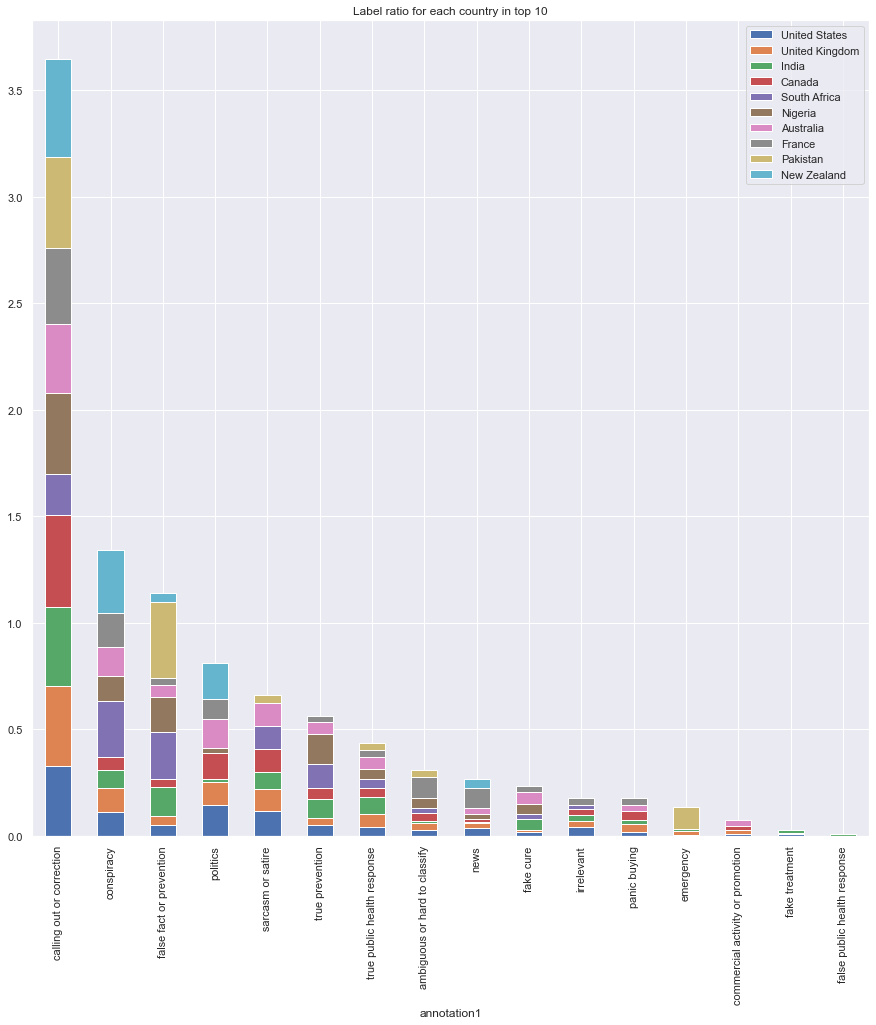

In [5]:
import pycountry
import seaborn as sns
sns.set_theme()

ct = pd.crosstab(t_with_l["annotation1"],t_with_l["country_code"])
columns = t_with_l["country_code"].value_counts().nlargest(10).index.to_list()
ct = ct[columns]
ct = ct/ct.sum()
ct = ct.reindex(ct.sum(axis=1).sort_values(ascending=False).index)
ct.columns = [pycountry.countries.get(alpha_2=c).name for c in ct.columns]
ct.plot(kind="bar",stacked=True, figsize=(15,15), title="Label ratio for each country in top 10")

Seems like there are some differences between countries and their ratio of different labels.

<AxesSubplot:title={'center':'Difference between ratio for true and false'}>

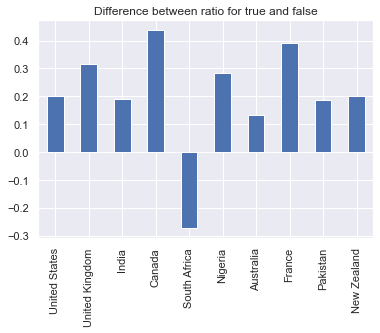

In [6]:
ct = pd.crosstab(t_with_l["annotation1"],t_with_l["country_code"])

def multi_to_binary(df):
    df = df.copy()

    mapping = {'calling out or correction': "true",
                'conspiracy': "false",
                'false fact or prevention': "false",
                'politics': "ambiguous",
                'sarcasm or satire': "false",
                'true prevention': "true",
                'true public health response': "true",
                'ambiguous or hard to classify': "ambiguous",
                'news': "true",
                'fake cure': "false",
                'irrelevant': "ambiguous",
                'panic buying': "ambiguous",
                'emergency': "true",
                'commercial activity or promotion': "ambiguous",
                'fake treatment': "false",
                'false public health response': "false"}
    df.index = [mapping[i] for i in df.index]
    df = df.reset_index()
    return df

ct = multi_to_binary(ct)
ct = ct.groupby("index").sum().drop("ambiguous")

columns = t_with_l["country_code"].value_counts().nlargest(10).index.to_list()
ct = ct[columns]
ct = ct/ct.sum()
ct.columns = [pycountry.countries.get(alpha_2=c).name for c in ct.columns]
ct = ct.T
(ct.true - ct.false).plot(kind="bar", title="Difference between ratio for true and false")

In [7]:
t_with_l_us = t_with_l.copy()
t_with_l_us = t_with_l_us[t_with_l_us.country_code == "us"]

t_with_l_us["state"].value_counts().nlargest(10).sum()/len(t_with_l) # # top 10 is about 30 % of all locations.

0.30403087478559176

<AxesSubplot:title={'center':'Difference between ratio for true and false'}, xlabel='state'>

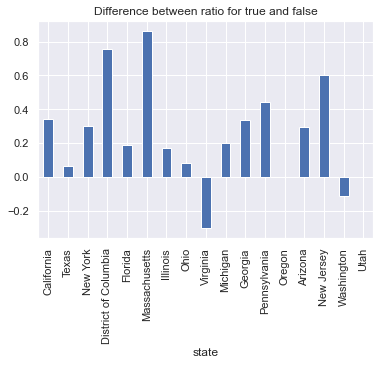

In [8]:
ct = pd.crosstab(t_with_l_us["annotation1"],t_with_l_us["state"])

ct = multi_to_binary(ct)
ct = ct.groupby("index").sum().drop("ambiguous")

columns = t_with_l_us.state.value_counts()[(t_with_l_us.state.value_counts() >= 20)].index
ct = ct[columns]
ct = ct/ct.sum()
ct = ct.T
(ct.true - ct.false).plot(kind="bar", title="Difference between ratio for true and false")

In [9]:
t_with_l.source.value_counts()

Twitter for iPhone            640
Twitter Web App               637
Twitter for Android           438
TweetDeck                     120
Twitter for iPad               84
                             ... 
Vimeo                           1
LatelyAI                        1
ContentCal Studio               1
General Physics Laboratory      1
DigitalTrans4m                  1
Name: source, Length: 74, dtype: int64

<AxesSubplot:title={'center':'Difference between ratio for true and false'}, xlabel='source'>

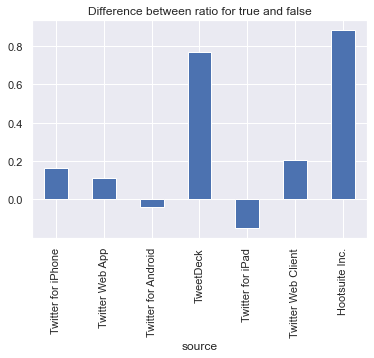

In [10]:
ct = pd.crosstab(t_with_l["annotation1"],t_with_l["source"])

ct = multi_to_binary(ct)
ct = ct.groupby("index").sum().drop("ambiguous")

columns = t_with_l.source.value_counts()[(t_with_l.source.value_counts() >= 50)].index
ct = ct[columns]
ct = ct/ct.sum()
ct = ct.T
(ct.true - ct.false).plot(kind="bar", title="Difference between ratio for true and false")

From the three above figures, the value of the respective variable in each figure seems to have some effect on the difference between true ratio and false ratio.

Something that needs to be remembered for all outputs is that the sample size in most cases is quite low.

In [11]:
tmp = multi_to_binary(t_with_l.set_index("annotation1")).rename(columns={"index": "annotation1"})
print(len(tmp[tmp.annotation1 == "true"]))
print(len(tmp[tmp.annotation1 == "false"]))

1132
719


In [12]:
%%capture

import pandas as pd
import us

miscov = pd.read_csv("../data/CMU_MisCov19_dataset_hydrated.csv")
miscov["date"] = pd.to_datetime(miscov.created_at).dt.date
miscov.country_code = miscov.country_code.str.upper()
miscov.state = miscov.state.str.upper()

def create_location_key(country_code, state):
    if country_code == "US" and not pd.isna(state):
        return country_code + "_" + us.states.lookup(state).abbr
    return country_code

miscov["location_key"] = miscov.apply(lambda x: create_location_key(x.country_code, x.state), axis=1)

chunks = []
for chunk in pd.read_csv("../data/covid19_open_data_aggregated.csv", chunksize=500000):
    chunk.date = pd.to_datetime(chunk.date).dt.date
    chunks.append(pd.merge(miscov, chunk, on=["date", "location_key"], how="inner"))

In [88]:
combined = pd.concat(chunks)
combined = combined[combined.location_key.notnull()]

mapping = {'calling out or correction': "true",
            'conspiracy': "false",
            'false fact or prevention': "false",
            'politics': "ambiguous",
            'sarcasm or satire': "false",
            'true prevention': "true",
            'true public health response': "true",
            'ambiguous or hard to classify': "ambiguous",
            'news': "true",
            'fake cure': "false",
            'irrelevant': "ambiguous",
            'panic buying': "ambiguous",
            'emergency': "true",
            'commercial activity or promotion': "ambiguous",
            'fake treatment': "false",
            'false public health response': "false"}

combined["label"] = combined["annotation1"].map(mapping)
combined = combined[combined.label != "ambiguous"]

combined.label = pd.factorize(combined.label)[0]
combined = combined.loc[:,~combined.columns.str.contains("cumulative")]
combined = combined.loc[:,~combined.columns.str.contains("population")]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='date', ylabel='label'>

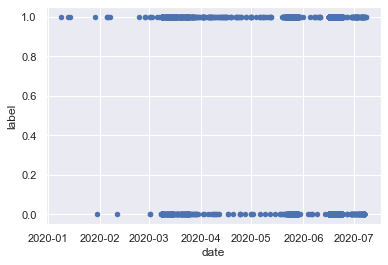

In [16]:
combined.plot("date", "label", kind="scatter")

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

tmp = combined.select_dtypes(["number"]).drop(columns=["tweet_id","author_id","openstreetmap_id", "longitude", "latitude"])
tmp = tmp.dropna(thresh = len(tmp)-200, axis = 1).dropna()

train, test = train_test_split(tmp, test_size=0.2)

test = test.sample(frac=1).groupby("label").head(test["label"].value_counts().min())

x_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

clf = LogisticRegression()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5


In [177]:
print(tmp[tmp.columns].corr()["label"].nlargest(11).iloc[1:])

mobility_residential            0.094972
life_expectancy                 0.057587
cancel_public_events            0.039810
contact_tracing                 0.039056
income_support                  0.034471
debt_relief                     0.031844
school_closing                  0.030293
workplace_closing               0.028010
public_information_campaigns    0.025858
stay_at_home_requirements       0.022475
Name: label, dtype: float64


In [175]:
tmp[tmp.columns].corr()["label"].nsmallest(10)

rainfall_mm                     -0.077114
new_confirmed                   -0.057853
minimum_temperature_celsius     -0.046029
dew_point                       -0.043126
maximum_temperature_celsius     -0.040757
average_temperature_celsius     -0.036829
facial_coverings                -0.024386
international_travel_controls   -0.021146
reply_count                     -0.020036
relative_humidity               -0.019924
Name: label, dtype: float64

In [185]:
keep = [
    "source", 
    "location_key", 
    "new_confirmed", 
    "new_deceased",
    "school_closing",
    "workplace_closing",
    "cancel_public_events",
    "restrictions_on_gatherings",
    "public_transport_closing",
    "stay_at_home_requirements",
    "restrictions_on_internal_movement",
    "international_travel_controls",
    "income_support",
    "debt_relief",
    "public_information_campaigns",
    "testing_policy",
    "contact_tracing", 
    "facial_coverings",
    "vaccination_policy",
    "stringency_index",
    "label",
    "rainfall_mm",
    "mobility_residential",
    "life_expectancy"
]

tmp2 = combined[keep]
tmp2.source = pd.factorize(tmp2.source)[0]
tmp2.location_key = pd.factorize(tmp2.location_key)[0]

train, test = train_test_split(tmp, test_size=0.2)

test = test.sample(frac=1).groupby("label").head(test["label"].value_counts().min())

x_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

clf = LogisticRegression()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5


C:\Users\mathi\anaconda3\envs\datmas\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
